# News Clustering using KMeans Algorithm
By Datetime : 2016-08-29 ~ 2016-09-05

In [1]:
import numpy as np
import pandas as pd
import articles_data_py3 as articles_data
from pymongo import MongoClient

## Load data from MongoDB 

In [2]:
client = MongoClient('mongodb://localhost:27017/somanews')
client.somanews.authenticate('ssomanews', 'ssomanews1029')
db = client.get_database('somanews')

crawled_collection = db.get_collection('crawledArticles')
clusters_collection = db.get_collection('articles')

## Select Categories
- 포함 : 경제, 문화, 건강, 과학, 사회, 정치, 스포츠
- 제외 : 종합, 정보없음, 인물, 사설

In [3]:
catelist_path = '../datastore/category.p'
headline_path = '../datastore/headline.p'

In [4]:
train = articles_data.find_recent_articles(crawled_collection, catelist_path)

## Preprocessing
1. Datetime (16-09-11 ~ 16-09-17)
2. Remove stopwords (regex, hanja)
3. POS Tagging with KoNLPy, Mecab
4. Using bigram

In [5]:
import datetime
from konlpy.tag import Mecab
import cnouns
import hanja
import re

In [6]:
mecab = Mecab()

In [7]:
def tokenize(data):
    return [' '.join(e for e in mecab.nouns(data))]

In [8]:
train['title_flat'] = train['title'].apply(lambda text: cnouns.text_cleaning_without_special_ch(text))
train['title_flat'] = train['title'].apply(lambda text: articles_data.remove_headlines(text, headline_path))
title = [tokenize(each[1]['title_flat']) for each in train.iterrows()]

## Training
1. Feature extraction - TfidVectorizer
2. Decomposition - PCA
3. Cluster - KMeans

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [10]:
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
title_flat = [item for sublist in title for item in sublist]
x_list = vectorizer.fit_transform(title_flat)

In [11]:
x_list_100d = PCA(n_components=100).fit_transform(x_list.toarray())
x_list_100d.shape

(2728, 100)

### Scoring

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Best Silhoutte Score

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
best_score = 0.0
best_k = 0

In [15]:
k_list = []
score_list = []
for k in range(15, 35):
    km = KMeans(n_clusters=k, n_jobs=-1).fit(x_list_100d)
    score = silhouette_score(x_list_100d, km.labels_)
    if best_score < score:
        best_score = score
        best_k = k
    k_list.append(k)
    score_list.append(score)
print("In Clusters =", best_k, ", Best score is : %0.3f" % best_score)

In Clusters = 31 , Best score is : 0.241


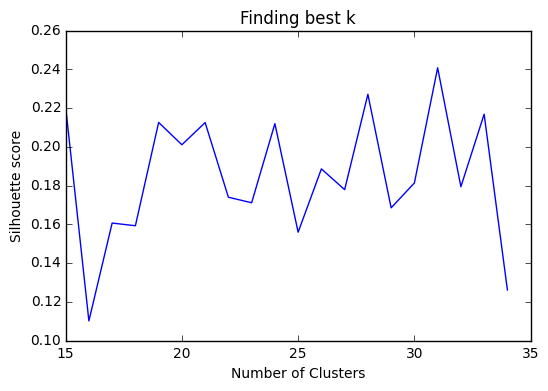

In [16]:
x = k_list
y = score_list
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.title('Finding best k')
plt.plot(x, y)
plt.show()

### K-Means Algorithm

In [17]:
km = KMeans(n_clusters=best_k, n_jobs=-1).fit(x_list_100d)
labels = km.labels_
centroids = km.cluster_centers_
print(km.inertia_)

272.315291506


In [18]:
train = train.drop(['title_flat'], axis=1)
train['cluster'] = labels

## Choose Best Cluster
- Minimum inertia

### Compare best cluster

In [19]:
sample_silhouette_values = silhouette_samples(x_list_100d, labels)
sample_silhouette_score = []
list_silhouette_score = []
best_cluster = []

for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]    
    list_silhouette_score.append(abs(ith_cluster_silhouette_values.mean()))

list_silhouette_score.sort(reverse=True)
sample_silhouette_score = list_silhouette_score[:12]

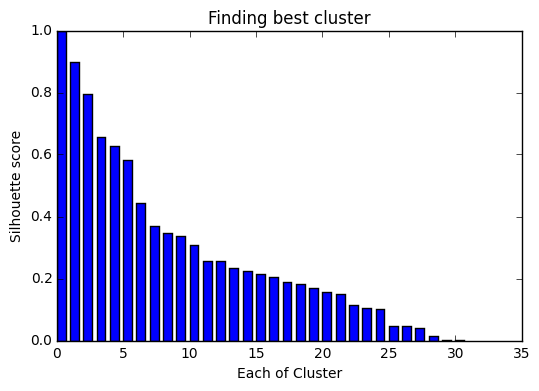

In [20]:
x = [x for x in range(best_k)]
y = list_silhouette_score
width = 1/1.5
plt.xlabel('Each of Cluster')
plt.ylabel('Silhouette score')
plt.title('Finding best cluster')
plt.bar(x, y, width)
plt.show()

In [21]:
sample_silhouette_score

[1.0,
 0.89886090539806496,
 0.79375158269639989,
 0.65641112195549178,
 0.62858998211003847,
 0.58338261246817924,
 0.44264791236575413,
 0.36846436033868901,
 0.34653859767721734,
 0.33580455467080711,
 0.30703767811315685,
 0.25792366852298027]

In [22]:
for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]
        
    if abs(ith_cluster_silhouette_values.mean()) in sample_silhouette_score:
        best_cluster.append(i)

In [23]:
train = train[train['cluster'].isin(best_cluster)]
train.cluster.unique()

array([17,  4, 24, 13,  6, 10, 16, 20, 18,  9, 27,  7])

## Result

In [24]:
cluster_data = []

for cluster_index in range(best_k):
    if cluster_index in best_cluster:
        cluster_data.append(train[train['cluster'] == cluster_index])
    
for i, d in enumerate(cluster_data):
    print('Cluster %d:' % (i), 'Size %d' % (len(d)))

    display(d[['title', 'category']].sample(min(len(train.cluster.unique()), len(d))))
    print('\n\n')

Cluster 0: Size 51


,title,category
2952,최순실 게이트로 경제정책도 갈팡질팡,뉴스 > 정치 > 정치일반
467,‘최순실 게이트’ 증시 타격··· 코스피 1980선도 무너져,마켓·비즈 > 금융·재테크
4179,[박근혜·최순실 게이트]야당 안 만나주자 국회의장에 “만나달라”,정치 > 정치일반
529,최순실 게이트로 ‘문재인 테마주’ 2배 급등 ‘테마주 난립’,경제 > 증권
3473,[박근혜·최순실 게이트]‘문고리 3인방’ 박 정부 1·2기 내내 ‘최순실 도우미’,정치 > 정치일반
4181,[박근혜·최순실 게이트]APEC 정상회의 박 대통령 ‘불참’,정치 > 정치일반
3483,"[박근혜·최순실 게이트]‘박정희 미화’ 소설 쓴 류철균, 박 대통령이 만든 재단 이사였다",정치 > 정치일반
4170,"[박근혜·최순실 게이트]“최순실, 미완성 청 문서 받아봐” 중간 결재권자 역할 정황 포착",정치 > 정치일반
2716,[박근혜·최순실 게이트]12일 ‘3차 촛불항쟁’…앞으로 1주일이 ‘현대사 중대 분수령’,정치 > 정치일반
2710,[박근혜·최순실 게이트]사정당국 관계자 “우병우도 국정농단 핵심”…특검 불가피,정치 > 정치일반





Cluster 1: Size 15


,title,category
3876,"[경향포토]김병준 총리 내정자, 말좀 합시다.",정치 > 정치일반
3061,[경향포토]둘러싸여 출근하는 김병준 총리내정자,정치 > 정치일반
3071,[경향포토]답변하는 김병준 총리내정자,정치 > 정치일반
3080,[경향포토]물 마시는 김병준 총리내정자,정치 > 정치일반
3081,[경향포토]물 마시는 김병준 총리 내정자,정치 > 정치일반
489,김병준 총리 내정자 “책임총리 권한행사 얘기 있었다”,정치 > 정치일반
3065,"[경향포토]김병준 총리 내정자, '사퇴거절'",정치 > 정치일반
2620,김병준 총리 내정자 “내가 왜 자진 사퇴하느냐”고 하지만…,정치 > 정치일반
3063,[경향포토]출근하는 김병준 총리내정자,정치 > 정치일반
3062,[경향포토]사무실 향하는 김병준 총리내정자,정치 > 정치일반





Cluster 2: Size 7


,title,category
2472,[경향포토]우병우 검찰 출석,사회 > 법원·검찰
2481,[경향포토]우병우 전 수석 검찰 출석,사회 > 법원·검찰
2479,[경향포토]우병우 검찰 출석,사회 > 법원·검찰
2448,"[경향포토]우병우, 드디어 검찰에",사회 > 사회일반
2445,[경향포토]'계급장' 뗀 우병우 검찰 출석,사회 > 사회일반
2478,[경향포토]우병우 검찰 출석,사회 > 법원·검찰
2474,[경향포토]우병우 검찰출석,사회 > 법원·검찰





Cluster 3: Size 25


,title,category
1912,[경향포토]최순실 관련 대국민담화 발표하는 박근혜 대통령,정치 > 청와대
1479,"박 대통령 내일 대국민담화 발표 … 청와대 핵심 관계자 ""검찰 수사 관련 입장 내놓...",정치 > 정치일반
1911,[경향포토]대통령 대국민담화 지켜보는 시민,정치 > 청와대
2141,[박 대통령 대국민담화]“최순실은 ‘개인사’ 도와준 사람” 구체 언급 없이 “수사 중”,정치 > 정치일반
2140,[박 대통령 대국민담화]대기업 발목 비튼 돈으로 벌린 사업 “미래 성장동력 꺼뜨리지...,정치 > 정치일반
1906,[경향포토]박근혜 대통령 대국민담화 발표,정치 > 청와대
1851,"與, 박 대통령 대국민담화에 ""결단해주셨다···강한 의지와 진정성 담은 호소""",정치 > 정치일반
1514,최순실 구속… 朴대통령 오늘 대국민 담화,정치
2994,'朴대통령 대국민 담화' 보여주자 펑펑 운 최순실… 혐의는 계속 부인,사회 > 법원ㆍ검찰ㆍ경찰
2134,[박 대통령 대국민담화]야 대권주자들 비판 일색,정치 > 국회·정당





Cluster 4: Size 25


,title,category
1914,[경향포토]국회 새누리당 찾은 비서실장,정치 > 정치일반
1020,"신임 대통령 비서실장에 DJ 비서실장, 한광옥 국민대통합위원장",정치 > 국회·정당
2555,"한광옥 대통령 비서실장 ""광화문 광장에서 보여준 국민 준엄한 뜻, 매우 무겁게 느껴""",정치 > 국회·정당
715,[11·2 기습 개각]“비서실장 누가 맡으려 할까” 뒤엉켜버린 인적쇄신 수순,정치 > 정치일반
1926,[경향포토]운영위 답변하는 한광옥 비서실장,정치 > 정치일반
1526,새 비서실장에 'DJ맨' 한광옥,정치 > 청와대
1909,[경향포토]국회 더불어민주당 찾은 비서실장,정치 > 정치일반
1917,"한광옥 청와대 비서실장 “대통령 사과, 어느 때보다 진실성 있어”",정치 > 정치일반
914,"靑 김규현 비서실장 대행 ""개각, 뉴스 보고 알았다""",정치 > 청와대
2233,"국회 인사 온 한광옥에 野圈 불편한 기색… 박지원 ""DJ 비서실장까지 지낸 분이…""",정치





Cluster 5: Size 8


,title,category
939,"'고장철' 인천지하철 2호선, 또 20분간 올스톱",사회 > 교통ㆍ관광ㆍ항공
3702,101일간 13차례 고장… 심장 떨리는 인천지하철 2호선,사회 > 교통ㆍ관광ㆍ항공
720,인천지하철 2호선 20분간 ‘스톱’,전국 > 서울·수도권 서울 경기 인천
491,인천지하철 2호선 고장…2시간째 운행 중단,전국 > 서울·수도권 서울 경기 인천
855,석달새 12차례… ‘사고鐵’ 인천지하철 2호선 19분간 올스톱,뉴스 > 사회 > 사회일반
3050,‘사고철’ 인천지하철 2호선 출근길 2시간 운행 중단,사회 > 사건·사고
446,인천지하철 2호선 전 구간 중단…선로변환기 이상,사회 > 전국
3047,인천지하철 2호선 출근길 또 중단…2시간만에 재개,사회 > 전국





Cluster 6: Size 4


,title,category
1062,[경향포토]니콘 액션카메라 키미션,테크 > PC·기기
1061,[경향포토]니콘 액션카메라 키미션 출시,테크 > PC·기기
1064,[경향포토]니콘 액션카메라,테크 > PC·기기
1060,[경향포토]니콘 키미션 액션카메라,테크 > PC·기기





Cluster 7: Size 15


,title,category
1017,"서울 강남4구·경기 과천, ‘분양권 전매‘ 시장 사라진다",부동산 >
1277,“강남4구·과천 분양권 전매금지”…투기꾼 지나간 뒤 ‘뒷북’,경제 > 경제일반
35,"3일 부동산 대책, 서울 강남3구만 정밀타격 예고에… 수도권은 투자 열기 확산",뉴스 > 경제 > 경제일반
1248,집값 안정보다 ‘과열 억제’에 방점 찍은 부동산 대책,경제 > 부동산
2853,"위례 등 공공택지 분양권 전매제한, 민간건설 아파트도 포함",뉴스 > 경제 > 경제일반
1054,서울 강남 4개구 분양권 전매 입주 때까지 금지,경제 > 부동산
1729,"강남 4구-과천 신규분양 아파트, 소유권이전 등기때까지 분양권 못팔아",뉴스 > 경제 > 경제일반
1305,[11·3 부동산 대책]이번에도…‘강남권 투기과열지구 지정’은 없다,부동산 >
1306,[11·3 부동산 대책]과열 지역 위주 ‘급한 불 끄기’··· 재건축·청약광풍 부산...,부동산 >
1025,[11·3 부동산 대책] “투기 수요 억제 효과“ “투기 광풍 잠재우기엔 역부족”,부동산 >





Cluster 8: Size 6


,title,category
1362,[경향포토]청계천 서울빛초롱축제,사회 > 사회일반
1363,[경향포토]청계천 '2016 서울빛초롱축제',사회 > 사회일반
1496,서울 청계천서 오늘부터 ‘빛초롱축제’ 연다,전국 > 서울·수도권 서울 경기 인천
1709,"서울빛초롱축제, 4일 청계천서 개막",뉴스 > 사회 > 사회일반
1355,[경향포토]서울빛초롱축제 내일 개막,사회 > 사회일반
1356,[경향포토]2016 서울 빛초롱 축제,사회 > 사회일반





Cluster 9: Size 5


,title,category
1177,[경향포토]외국인 학생 패션쇼 - 1,사회 > 사회일반
1173,[경향포토]외국인 학생 패션쇼 - 5,사회 > 사회일반
1174,[경향포토]외국인 학생 패션쇼 - 4,사회 > 사회일반
1176,[경향포토]외국인 학생 패션쇼 - 2,사회 > 사회일반
1175,[경향포토]외국인 학생 패션쇼 - 3,사회 > 사회일반





Cluster 10: Size 15


,title,category
3227,"'굿판 참여' 박승주 안전처 장관 내정자 ""환태평양 지진대가 활동해서"" 해명",사회 > 사회일반
3354,[카드뉴스] 장관 내정자와 굿판,사회 > 카드뉴스
3044,안전처 장관 내정자 “명상 통해 47가지 모습으로 지구 왔다”,정치 > 정치BAR
3681,'명상 중 전봉준 장군에게 책 받았다'는 박승주 내정자,정치 > 청와대
3130,"‘전생 안전처’ 장관? 박승주 후보자, 전생 체험 고백 책도 썼다",사회 > 사회일반
3553,[횡설수설/송평인]안전처 장관 후보자의 굿판,뉴스 > 정치 > 정치일반
654,박승주 국민안전처 장관은 누구?,정치 > 청와대
870,‘안전’ 경력 없는 국민안전 사령탑,뉴스 > 정치 > 정치일반
3103,"박승주 국민안전처 장관 내정자, 굿판 참석·47회 전생 고백 논란",사회 > 전국
3447,광화문 한복판 굿판 참석하고 전봉준 만났다는 장관 내정자,정치 > 정치일반





Cluster 11: Size 11


,title,category
3302,[경향포토]박 대통령 하야 촉구 텐트 농성,사회 > 사회일반
3301,[경향포토]텐트 농성 벌이는 문화예술인들,사회 > 사회일반
1949,[경향포토]예술인들 텐트 빼앗는 경찰,사회 > 사건·사고
1956,[경향포토]문화예술인 시국선언 농성텐트 끌어내는 경찰,사회 > 사건·사고
3299,[경향포토]광화문 예술인 텐트농성,사회 > 사회일반
1940,[경향포토]예술인들의 노숙농성 막는 경찰,사회 > 사건·사고
1958,[경향포토]예술인 텐트 농성 막는 경찰,사회 > 사건·사고
1959,[경향포토]문화예술인들의 시국선언...텐트 농성 막는 경찰,사회 > 사건·사고
1955,[경향포토]예술인들 농성 텐트 막는 경찰,사회 > 사건·사고
1965,[경향포토]책 읽으며 농성,사회 > 사건·사고


## Save Dataframe to MongoDB

In [25]:
client = MongoClient('mongodb://localhost:27017/somanews')
client.somanews.authenticate('ssomanews', 'ssomanews1029')
db = client.get_database('somanews')
articles = db.get_collection('articles')

In [26]:
articles.insert_many(train.to_dict(orient='records'))
client.close()